## There are three sections here. See instructions below.
Section 1 should be run using qiskit-terra master. This will cause standard compilation of RX(theta) into pulses.

Section 2 should be run using Pranav's qiskit-terra fork, which will compile to a direct RX(theta) rotation. So after running Section 1, switch to the qiskit-terra fork, and restart the kernel.

Section 3 is data analysis, which can be run with either qiskit-terra version. Easiest to keep running same fork, no need to restart kernel.

In [10]:
qubit_num = 0  # or change to a qubit that has bad coherence

---
## Section 1: Standard Compilation (run with qiskit-terra master)

In [2]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [4]:
import pulse_compiler_helper_fns

In [7]:
q.IBMQ.load_account() # Load account from disk

Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
config = backend.configuration()
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [7]:
num_angles = 17  # will exclude endpoints of 0 and 2pi
angles = np.linspace(0, np.pi, num_angles+1, endpoint=False)[1:]  # get rid of endpoints
print(angles)

[ 0.17453293  0.34906585  0.52359878  0.6981317   0.87266463  1.04719755
  1.22173048  1.3962634   1.57079633  1.74532925  1.91986218  2.0943951
  2.26892803  2.44346095  2.61799388  2.7925268   2.96705973]


In [8]:
schedules = []
for angle in angles:
    schedule = cmd_def.get('u3', [qubit_num], P0=angle, P1=3*np.pi/2, P2=np.pi/2)  # RX(angle) = U3(angle, 3pi/2, pi/2)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

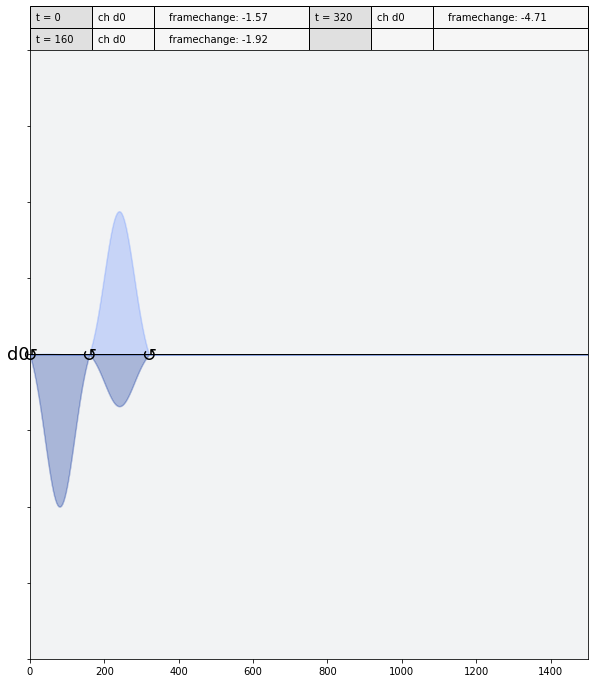

In [13]:
# sanity check, show a schedule
schedules[10].draw(plot_range=(0, 1500), channels=[config.drive(0)])

In [14]:
shots = 1000
standard_job = q.execute(schedules, backend=backend, shots=shots)
print(standard_job.job_id())

5dd45214407b8c0019f72135


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


------
## Section 2: Direct RX (Switch to Pranav's qiskit-terra fork, then restart kernel but don't clear output)

In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [6]:
q.IBMQ.load_account() # Load account from disk

Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
config = backend.configuration()
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [8]:
num_angles = 17  # will exclude endpoints of 0 and 2pi
angles = np.linspace(0, np.pi, num_angles+1, endpoint=False)[1:]  # get rid of endpoints
print(angles)

[ 0.17453293  0.34906585  0.52359878  0.6981317   0.87266463  1.04719755
  1.22173048  1.3962634   1.57079633  1.74532925  1.91986218  2.0943951
  2.26892803  2.44346095  2.61799388  2.7925268   2.96705973]


In [11]:
schedules = []
for angle in angles:
    circuit = q.QuantumCircuit(20)
    circuit.rx(angle, qubit_num)
    decomposed_circuit = circuit.decompose()
    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

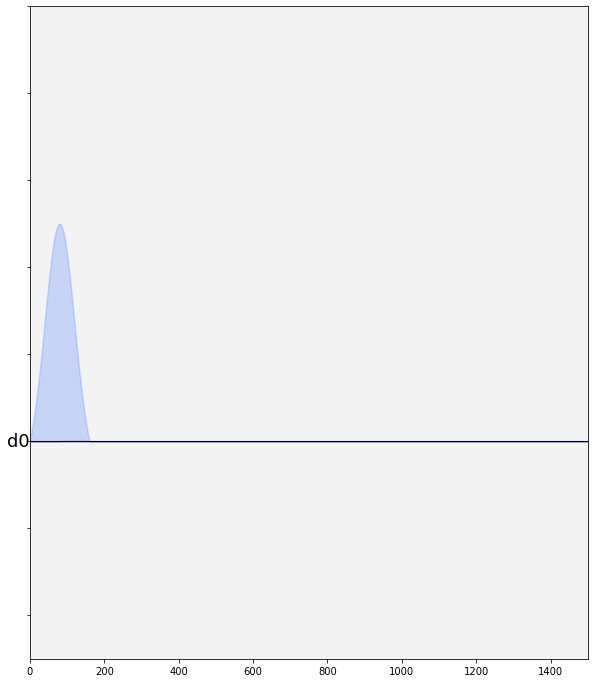

In [12]:
# sanity check, show a schedule
schedules[10].draw(plot_range=(0, 1500), channels=[config.drive(0)])

In [13]:
shots = 1000
direct_job = q.execute(schedules, backend=backend, shots=shots)
print(direct_job.job_id())

5dd453edf501cd001811d73f


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


---
## Section 3: Data Analysis

In [14]:
standard_job = backend.retrieve_job('5dd45214407b8c0019f72135')
direct_job = backend.retrieve_job('5dd453edf501cd001811d73f')

In [27]:
direct_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [28]:
standard_result = standard_job.result()
direct_result = direct_job.result()

In [29]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [30]:
standard_fracs = []
for i in range(num_angles):
    counts = marginal_counts(standard_result.get_counts(i), meas_qubits=[qubit_num])
    standard_fracs.append(counts.get('1', 0) / shots)
print(standard_fracs)

direct_fracs = []
for i in range(num_angles):
    counts = marginal_counts(direct_result.get_counts(i), meas_qubits=[qubit_num])
    direct_fracs.append(counts.get('1', 0) / shots)
print(direct_fracs)

[0.032, 0.075, 0.112, 0.127, 0.178, 0.241, 0.353, 0.442, 0.508, 0.57, 0.647, 0.74, 0.766, 0.832, 0.878, 0.924, 0.907]
[0.034, 0.054, 0.094, 0.144, 0.183, 0.253, 0.355, 0.382, 0.514, 0.573, 0.659, 0.737, 0.781, 0.848, 0.888, 0.917, 0.921]


[0, 3.141592653589793, 0, 1]

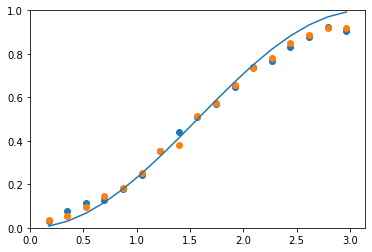

In [31]:
plt.scatter(angles, standard_fracs)
plt.scatter(angles, direct_fracs)
plt.plot(angles, [np.sin(angle / 2) ** 2 for angle in angles])
plt.axis([0, np.pi, 0, 1])